# Conformal Prediction for classification

This notebook will performal conformal prediction for classification manually, and also use the Python Package MAPIE (https://pypi.org/project/MAPIE/).

If necessary, `pip install mapie`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_mean_width_score

## Create data

Example data will be produced using SK-Learn's `make_blobs` method.

In [2]:
n_classes = 4
# Make train and test data
X, y = make_blobs(
    n_samples=10000, n_features=3, centers=n_classes, cluster_std=3.5, random_state=13)

# Split off model training set
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.5, random_state=42)
# Split rest into calibration and test
X_Cal, X_test, y_cal, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

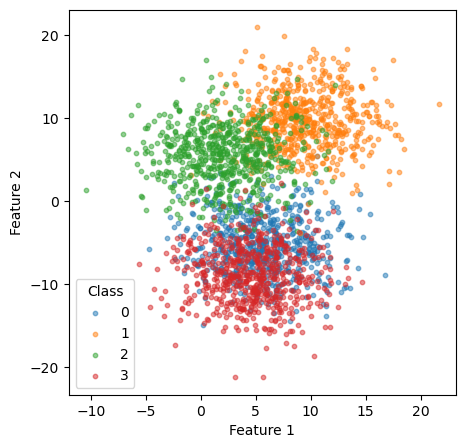

In [3]:
# Plot the data
fig = plt.subplots(figsize=(5, 5))
ax = plt.subplot(111)
for i in range(n_classes):
    ax.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1], label=i, alpha=0.5, s=10)
legend = ax.legend()
legend.set_title("Class")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()

## 'Manual' method

### Build and train the classifier

Use the training set to train a logistic regression classifier.

In [4]:
# Buildand train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

### Calculate conformal prediction threshold

We will now predict classiifcation probabilitlites of the calibration set. This will be used to set a classification threshold for new data.

In [5]:
# Get predictions for calibration set
y_pred = classifier.predict(X_Cal)
y_pred_proba = classifier.predict_proba(X_Cal)

# Show first 5 instances
y_pred_proba[0:5]

array([[9.19706708e-08, 7.65162679e-01, 2.34837227e-01, 2.44506155e-09],
       [1.97489030e-05, 9.85414797e-01, 1.42228996e-02, 3.42554388e-04],
       [1.42521752e-05, 9.54716818e-02, 9.04514062e-01, 4.25878921e-09],
       [7.27902991e-03, 1.19873648e-05, 1.47988075e-04, 9.92560995e-01],
       [8.54109906e-06, 8.36599076e-10, 6.63371386e-08, 9.99991392e-01]])

### Calculate $s_i$ scores

Here we will calculate $s_i$ scores only based on looking at probabilities associated with the observed class.

For each instance we will get the predicted probability for the class of that instance.

The $s_i$ score (non-conformality) is $1-probability$.

The higher the $s_i$ score, the less that example conforms to that class.

In [6]:
si_scores = []
# Loop through all calibration instances
for i, true_class in enumerate(y_cal):
    # Get predicted probability for observed/true class
    predicted_prob = y_pred_proba[i][true_class]
    si_scores.append(1 - predicted_prob)    

# Convert to NumPy array
si_scores = np.array(si_scores)

# Show first 5 instances
si_scores[0:5]

array([7.65162773e-01, 1.45852029e-02, 9.04528318e-01, 7.43900535e-03,
       8.60827280e-06])

### Get 95th percentile threshold

The threshold determines what *coverage* our classification will have. Coverage refers to the proportion of predictions that actually contain the true outcome. 

The threshold is the percentile corresponding to $1-alpha$. To get 95% coverage, we set an alpha of 0.05.

When used in real life, the quantile level (based on 𝛼) requires a finite sample correction to calculate the corresponding quantile 𝑞. We multiple 0.95  by $(n+1)/n$, which means that 𝑞𝑙𝑒𝑣𝑒𝑙 would be 0.951 for n = 1000. We will ignore that correction here.

In [7]:
number_of_samples = len(X_Cal)
alpha = 0.05
qlevel = (1 - alpha) * ((number_of_samples + 1) / number_of_samples)
threshold = np.percentile(si_scores, qlevel*100)
print(f'Threshold: {threshold:0.3f}')

Threshold: 0.779


Show chart of $s_1$ values, with cut-off threshold.

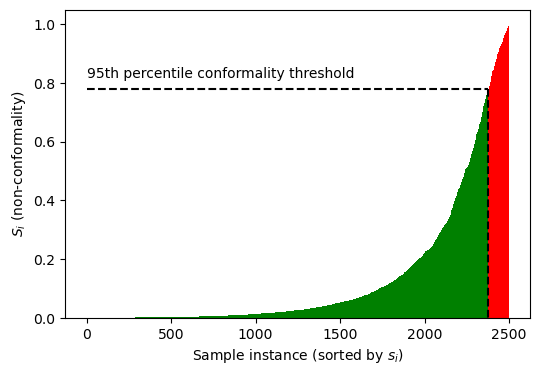

In [8]:
x = np.arange(len(si_scores)) + 1
sorted_si_scores = np.sort(si_scores)
index_of_95th_percentile = int(len(si_scores) * 0.95)

# Color by cut-off
conform = 'g' * index_of_95th_percentile
nonconform = 'r' * (len(si_scores) - index_of_95th_percentile)
color = list(conform + nonconform)

fig = plt.figure(figsize=((6,4)))
ax = fig.add_subplot()

# Add bars
ax.bar(x, sorted_si_scores, width=1.0, color = color)

# Add lines for 95th percentile
ax.plot([0, index_of_95th_percentile],[threshold, threshold], 
        c='k', linestyle='--')
ax.plot([index_of_95th_percentile, index_of_95th_percentile], [threshold, 0],
        c='k', linestyle='--')

# Add text
txt = '95th percentile conformality threshold'
ax.text(5, threshold + 0.04, txt)

# Add axis labels
ax.set_xlabel('Sample instance (sorted by $s_i$)')
ax.set_ylabel('$S_i$ (non-conformality)')

plt.show()

### Get samples/classes from test set classified as positive

We can now find all those model outputs less than the threshold.

It is possible for an individual example to have no value, or more than one value, below the threshold.

In [9]:
prediction_sets = (1 - classifier.predict_proba(X_test) <= threshold)
prediction_sets[0:10]

array([[ True, False, False, False],
       [ True, False, False,  True],
       [ True, False,  True, False],
       [False, False,  True, False],
       [False,  True, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False,  True],
       [False,  True, False, False],
       [ True, False,  True, False]])

### Show coverage and average set size

*Coverage* is the proportion of prediction sets that actually contain the true outcome.

*Average set size* is the average number of predicted classes per instance.

In [10]:
# Get coverage and average set size
cov = classification_coverage_score(y_test, prediction_sets)
setsize = classification_mean_width_score(prediction_sets)
print(f'Coverage: {cov:0.2f}')
print(f'Avg. set size: {setsize:.2f}')

Coverage: 0.95
Avg. set size: 1.16


Show class-wise performance.

NOTE: The standard scoring method guarantees coverage across the data set, but does not guarantee coverage for all classes. The method may be modified to use thresholds for each class (see end of the notebook for adaptations to the general method.)


In [11]:
def class_wise_performance(y_new, y_set, n_classes):
    df = pd.DataFrame()
    # Loop through the classes
    for i in range(n_classes):
    # Calculate the coverage and set size for the current class
        ynew = y_new[y_new == i]
        yscore = y_set[y_new == i]
        cov = classification_coverage_score(ynew, yscore)
        size = classification_mean_width_score(yscore)
        # Create a new dataframe with the calculated values
        temp_df = pd.DataFrame({
            "class": [i],
            "coverage": [cov],
            "avg. set size": [size]
            }, index = [i])
        # Concatenate the new dataframe with the existing one
        df = pd.concat([df, temp_df])
    df.set_index('class', inplace=True)
    return(df)

In [12]:
print(class_wise_performance(y_test, prediction_sets, n_classes))

       coverage  avg. set size
class                         
0      0.945902       1.154098
1      0.955056       1.149278
2      0.930233       1.229457
3      0.974277       1.099678


## MAPIE example

### Split into train and test sets

We will use mapie's k-fold calibration/test method to get assessment of the whole test set, so there is no need for calibration/test here.

In [13]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

### Train model and MAPIE classifier

MAPIE wraps around any model. It fits the model and gets the prediction sets.

The `score` method is the same as used above. This method may be used with k-fold MAPIE fitting which fits a model and then gives us prediction sets across the whole test set by using k-fold calibration/test. 

In [14]:
# Define classifier
classifier = LogisticRegression()
mapie_score = MapieClassifier(estimator=classifier, method='score', cv=5)
# Fit classifier and get predictions
mapie_score.fit(X_train, y_train)
y_pred, y_set = mapie_score.predict(X_test, alpha=0.05)
# Remove redundant dimension (used if more than one alpha is used)
y_set = np.squeeze(y_set)
# Show first 5 instances
print(y_set[0:5])

[[False False False  True]
 [ True False False False]
 [ True False  True  True]
 [False  True False False]
 [False  True  True False]]


Get coverage.

In [15]:
# Full coverage
cov = classification_coverage_score(y_test, y_set)
setsize = classification_mean_width_score(y_set)
print(f'Coverage: {cov:0.2f}')
print(f'Avg. set size: {setsize:.2f}')

Coverage: 0.95
Avg. set size: 1.13


In [16]:
# Get class-wise performance
print('Class wise performance')
print(class_wise_performance(y_test, y_set, n_classes))

Class wise performance
       coverage  avg. set size
class                         
0      0.946414       1.117415
1      0.956918       1.143331
2      0.915323       1.200000
3      0.975857       1.066978


## Method adaptations

The method may be adapted in various ways:

- *Adaptive methods* can be better when some examples are easier to classify than others, or when there is easy confusion between groups (tigers vs lions, for example). These can produce large sets, but RAPS (Regualirised Adaptive Prediction Sets) includes a penalty to reduce this problem.

- *Group-balanced* conformal prediction guarantees coverage for groups in the data. If there are separate groups where it is essential to get equal coverage (e.g. race), then calculate thresholds for each group separately. This method relies on having sufficent data for reliable subgroups.

- *Class-conditional* conformal prediction guarantees coverage for all classes. This uses class as the grouping method. This can tend to increase set size as coverage must be for all classes, and the the most difficult class to classify may be 'triggered' most.

- *Top K* gives fixed size prediction sets. It selects $k$ instances that have the lowest non-conformity score.

Some of these methods require prefitting of a model with calibration, rather than being able to use MAPIE's k-fold method.